<h1><center><font size="6">Santandar Bank Customer Transcation EDA and Modelling</font></center></h1>

<h2><center><font size="4">Dataset obtained from "Santander Customer Transaction Prediction" from a Kaggle Competition</font></center></h2>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Intro and Business Problem</a>  
- <a href='#2'>Preparing the data</a>  
- <a href='#3'>Data exploration</a>   
 - <a href='#31'>Glimpse of the data</a>   
 - <a href='#32'>Density plots of features</a>   
 - <a href='#33'>Distribution of mean and std</a>   
 - <a href='#34'>Distribution of min and max</a>      
 - <a href='#36'>Features correlations</a>   
 - <a href='#37'>Duplicate values</a>   
- <a href='#5'>Modelling</a>

# <a id='1'>Intro and Business Problem</a>  

Santander Bank needs to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. 

The data provided for this competition has the same structure as the real data they have available to solve this problem.  
The data is anonimyzed, each row containing 200 numerical values identified just with a number.  

In the following we will be exploring the data, preparing it for a model, training a model and predicting the target value for the test set(scoring).

# <a id='2'>Preparing the data</a>  


## Loading the packages


In [41]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb #https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

## Loading the data   

In [2]:
%%time
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

Wall time: 14.8 s


# <a id='3'>Data exploration</a>  

## <a id='31'>   Glimpse of the data:</a>  

Let's check the shape of train and test data:

In [3]:
df_train.shape, df_test.shape

((200000, 202), (200000, 201))

Train data has 200,000 entries and 202 columns.

Test data has 200,000 entries and 201 columns ( target variable absent ).

Let's have a look at some samples of the training and test set:

In [4]:
df_train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [5]:
df_test.head()

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595   

     var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.2675  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669   
1  18.6316 -4.4131  ...  10.6165   8.8349   0.9403  10.1282  15.5765   0.4773   
2  20.2537  1.5233  ...  -0.7484  10.9935   1.9803   2.1800  12.9813   2.1281   
3  20.5660  3.3755  ...   9.5702   9.0766   1.6580   3.5813  15.1874   3.1656   
4  10.6048  2.9890  ...   4.2259   9.1723   1.2835   3.3778  19.5542  -0.2860   

   var_196  var_197  var_198  var_199  
0   4.3654  10.7200  15.4722  -8.7197  
1  -1.4852   9.8714  19.1293 -20.9760  
2  -7.1086   7.0618  19.8956 -23.1794  
3   3.9567   9.2295  13.0168  -4.2108  
4  -5.1612   7.2882  13.9260  -9.1846  

[5 rows x 201 columns]

Let's now check the type and also if there are any missing data in our training and testing dataset:

In [6]:
def data_vis(data):
    total_missing = data.isnull().sum()
    percentage_missing = (data.isnull().sum()/data.isnull().count()*100)
    data_vis_df = pd.concat([total_missing, percentage_missing], axis=1, keys=['Total Missing Values', 'Percentage of Missing Values'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    data_vis_df['Types'] = types
    return(np.transpose(data_vis_df))

In [7]:
%%time
# we have no missing values in Train set
print("Train set missing values test:  ",df_train.isnull().any().any())
# we have no missing values in Test set
print("Test set missing values test:  ",df_test.isnull().any().any())

Train set missing values test:   False
Test set missing values test:   False
Wall time: 500 ms


In [8]:
data_vis(df_train)

ID_code target    var_0    var_1    var_2  \
Total Missing Values               0      0        0        0        0   
Percentage of Missing Values       0      0        0        0        0   
Types                         object  int64  float64  float64  float64   

                                var_3    var_4    var_5    var_6    var_7  \
Total Missing Values                0        0        0        0        0   
Percentage of Missing Values        0        0        0        0        0   
Types                         float64  float64  float64  float64  float64   

                              ...  var_190  var_191  var_192  var_193  \
Total Missing Values          ...        0        0        0        0   
Percentage of Missing Values  ...        0        0        0        0   
Types                         ...  float64  float64  float64  float64   

                              var_194  var_195  var_196  var_197  var_198  \
Total Missing Values                0        0        0        0        0   
Percentage of Missing Values        0        0        0        0        0   
Types                         float64  float64  float64  float64  float64   

                              var_199  
Total Missing Values                0  
Percentage of Missing Values        0  
Types                         float64  

[3 rows x 202 columns]

Let's also check the test dataset:

In [9]:
%%time
data_vis(df_test)

Wall time: 1.07 s


ID_code    var_0    var_1    var_2    var_3  \
Total Missing Values               0        0        0        0        0   
Percentage of Missing Values       0        0        0        0        0   
Types                         object  float64  float64  float64  float64   

                                var_4    var_5    var_6    var_7    var_8  \
Total Missing Values                0        0        0        0        0   
Percentage of Missing Values        0        0        0        0        0   
Types                         float64  float64  float64  float64  float64   

                              ...  var_190  var_191  var_192  var_193  \
Total Missing Values          ...        0        0        0        0   
Percentage of Missing Values  ...        0        0        0        0   
Types                         ...  float64  float64  float64  float64   

                              var_194  var_195  var_196  var_197  var_198  \
Total Missing Values                0        0        0        0        0   
Percentage of Missing Values        0        0        0        0        0   
Types                         float64  float64  float64  float64  float64   

                              var_199  
Total Missing Values                0  
Percentage of Missing Values        0  
Types                         float64  

[3 rows x 201 columns]

Looks like there is no missing data in training and testing data. 

Since all the variables are numerical, let's use the describe function now to get some information of training and testing data:

In [10]:
%%time
df_train.describe()

Wall time: 2.5 s


target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545850       0.284162  ...       3.234440       7.438408   
std         3.418076       3.332634  ...       4.559922       3.023272   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
25%        13.943800      -2.317800  ...      -0.058825       5.157400   
50%        16.456800       0.393700  ...       3.203600       7.347750   
75%        19.102900       2.937900  ...       6.406200       9.512525   
max        27.691800      10.151300  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927839       3.331774      17.993784      -0.142088   
std         1.478423       3.992030       3.135162       1.429372   
min        -3.814500     -11.783400       8.694400      -5.261000   
25%         0.889775       0.584600      15.629800      -1.170700   
50%         1.901300       3.396350      17.957950      -0.172700   
75%         2.949500       6.205800      20.396525       0.829600   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303335       8.908158      15.870720      -3.326537  
std         5.454369       0.921625       3.010945      10.438015  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.946925       8.252800      13.829700     -11.208475  
50%         2.408900       8.888200      15.934050      -2.819550  
75%         6.556725       9.593300      18.064725       4.836800  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [11]:
%time
df_test.describe()

Wall time: 0 ns


var_0          var_1          var_2          var_3  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       10.658737      -1.624244      10.707452       6.788214   
std         3.036716       4.040509       2.633888       2.052724   
min         0.188700     -15.043400       2.355200      -0.022400   
25%         8.442975      -4.700125       8.735600       5.230500   
50%        10.513800      -1.590500      10.560700       6.822350   
75%        12.739600       1.343400      12.495025       8.327600   
max        22.323400       9.385100      18.714100      13.142000   

               var_4          var_5          var_6          var_7  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       11.076399      -5.050558       5.415164      16.529143   
std         1.616456       7.869293       0.864686       3.424482   
min         5.484400     -27.767000       2.216400       5.713700   
25%         9.891075     -11.201400       4.772600      13.933900   
50%        11.099750      -4.834100       5.391600      16.422700   
75%        12.253400       0.942575       6.005800      19.094550   
max        16.037100      17.253700       8.302500      28.292800   

               var_8          var_9  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean        0.277135       7.569407  ...       3.189766       7.458269   
std         3.333375       1.231865  ...       4.551239       3.025189   
min        -9.956000       4.243300  ...     -14.093300      -2.407000   
25%        -2.303900       6.623800  ...      -0.095000       5.166500   
50%         0.372000       7.632000  ...       3.162400       7.379000   
75%         2.930025       8.584825  ...       6.336475       9.531100   
max         9.665500      11.003600  ...      20.359000      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.925944       3.322016      17.996967      -0.133657   
std         1.479966       3.995599       3.140652       1.429678   
min        -3.340900     -11.413100       9.382800      -4.911900   
25%         0.882975       0.587600      15.634775      -1.160700   
50%         1.892600       3.428500      17.977600      -0.162000   
75%         2.956000       6.174200      20.391725       0.837900   
max         8.005000      17.632600      27.947800       4.545400   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.290899       8.912428      15.869184      -3.246342  
std         5.446346       0.920904       3.008717      10.398589  
min       -13.944200       6.169600       6.584000     -39.457800  
25%        -1.948600       8.260075      13.847275     -11.124000  
50%         2.403600       8.892800      15.943400      -2.725950  
75%         6.519800       9.595900      18.045200       4.935400  
max        15.920700      12.275800      26.538400      27.907400  

[8 rows x 200 columns]

Let's now plot the **distribution of the variables**. 

**X- axis** represent the **values**.

**Y- axis** represent the **frequency**. 

We will be plotting the **first 28 columns** and the **last 28 columns** only:

Distributions of first 28 columns of training data


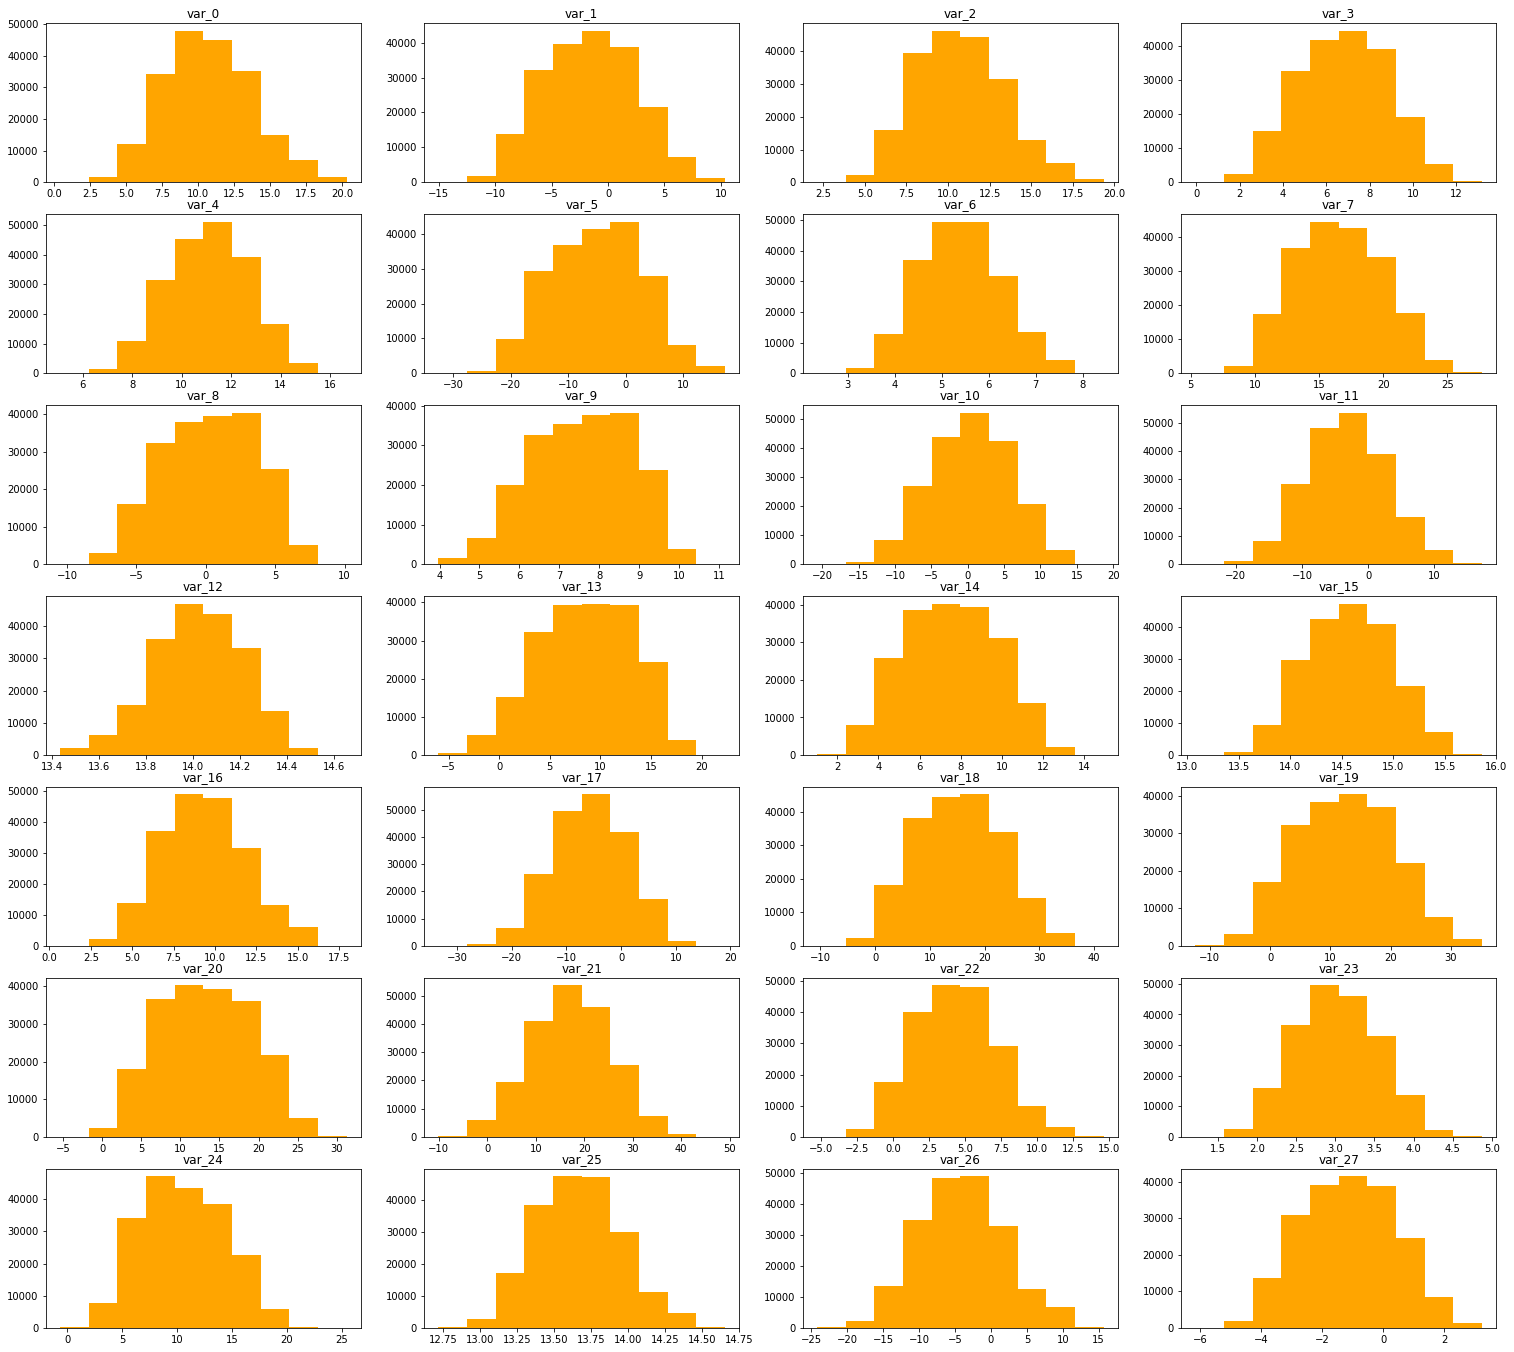

In [12]:
print('Distributions of first 28 columns of training data')

plt.figure(figsize=(26, 24))
for i, col in enumerate(list(df_train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(df_train[col], color = "Orange")
    plt.title(col)

Distributions of the last 28 columns of training data


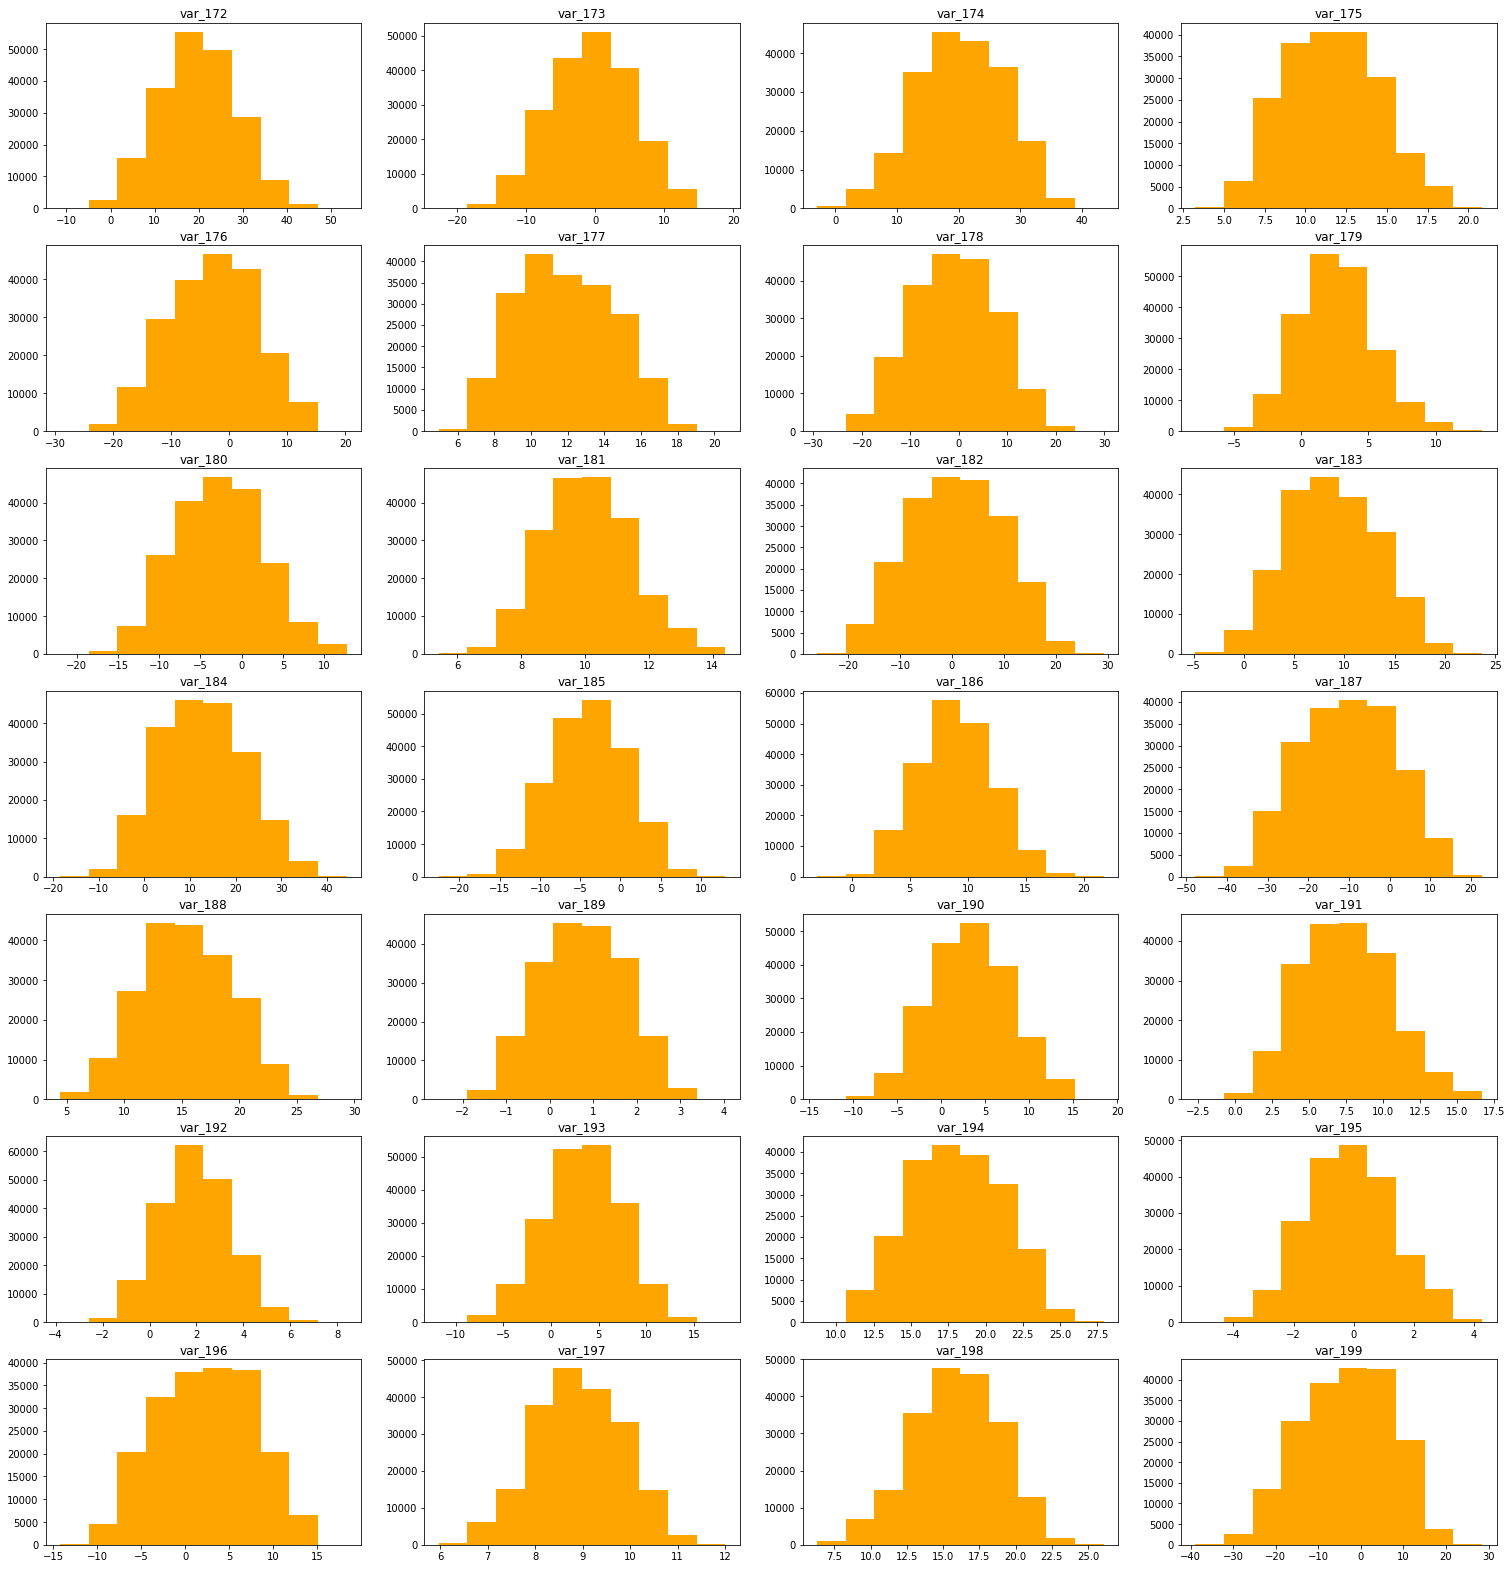

In [13]:
print('Distributions of the last 28 columns of training data')

plt.figure(figsize=(26, 28))
for i, col in enumerate(list(df_train.columns)[174:202]):
    plt.subplot(7, 4, i + 1)
    plt.hist(df_train[col],color = "Orange")
    plt.title(col)

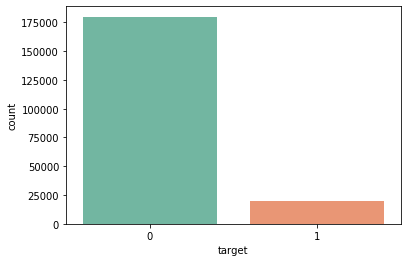

In [14]:
sns.countplot(df_train['target'], palette='Set2')

In [15]:
print (df_train['target'].value_counts())
df_train['target'].value_counts(normalize = True)

0    179902
1     20098
Name: target, dtype: int64


0    0.89951
1    0.10049
Name: target, dtype: float64

We can make few observations here:   

* Standard deviation is relatively **large** for both training and testing data
 
* Mean values for both training and testing are distributed over a **large range**. Variables are quite different from each other.

* Min, max, mean, std values for train and test data are **quite close** to each other.

* Target variable is binary and has class imbalance: **10% of samples belonging to 1 class**;


## <a id='32'>Density plots of features</a>  

Let's show now the density plot of variables in train dataset. 

## Comparision of 0 and 1 class in training data for each variable 

We will be representing with different **colors** the **distribution** for values with **target** value **0** and **1**.

In [16]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('darkgrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(22,25))
    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        #A distplot plots a univariate distribution of observations. 
        #The distplot() function combines the matplotlib hist function with the seaborn kdeplot() and rugplot() functions.
        sns.distplot(df1[feature], hist=False,label=label1,color = "red")
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=5, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=5)
    plt.show();

The first 100 variables from **var_0** till **var_99** are depicted in the following cell:

<Figure size 432x288 with 0 Axes>

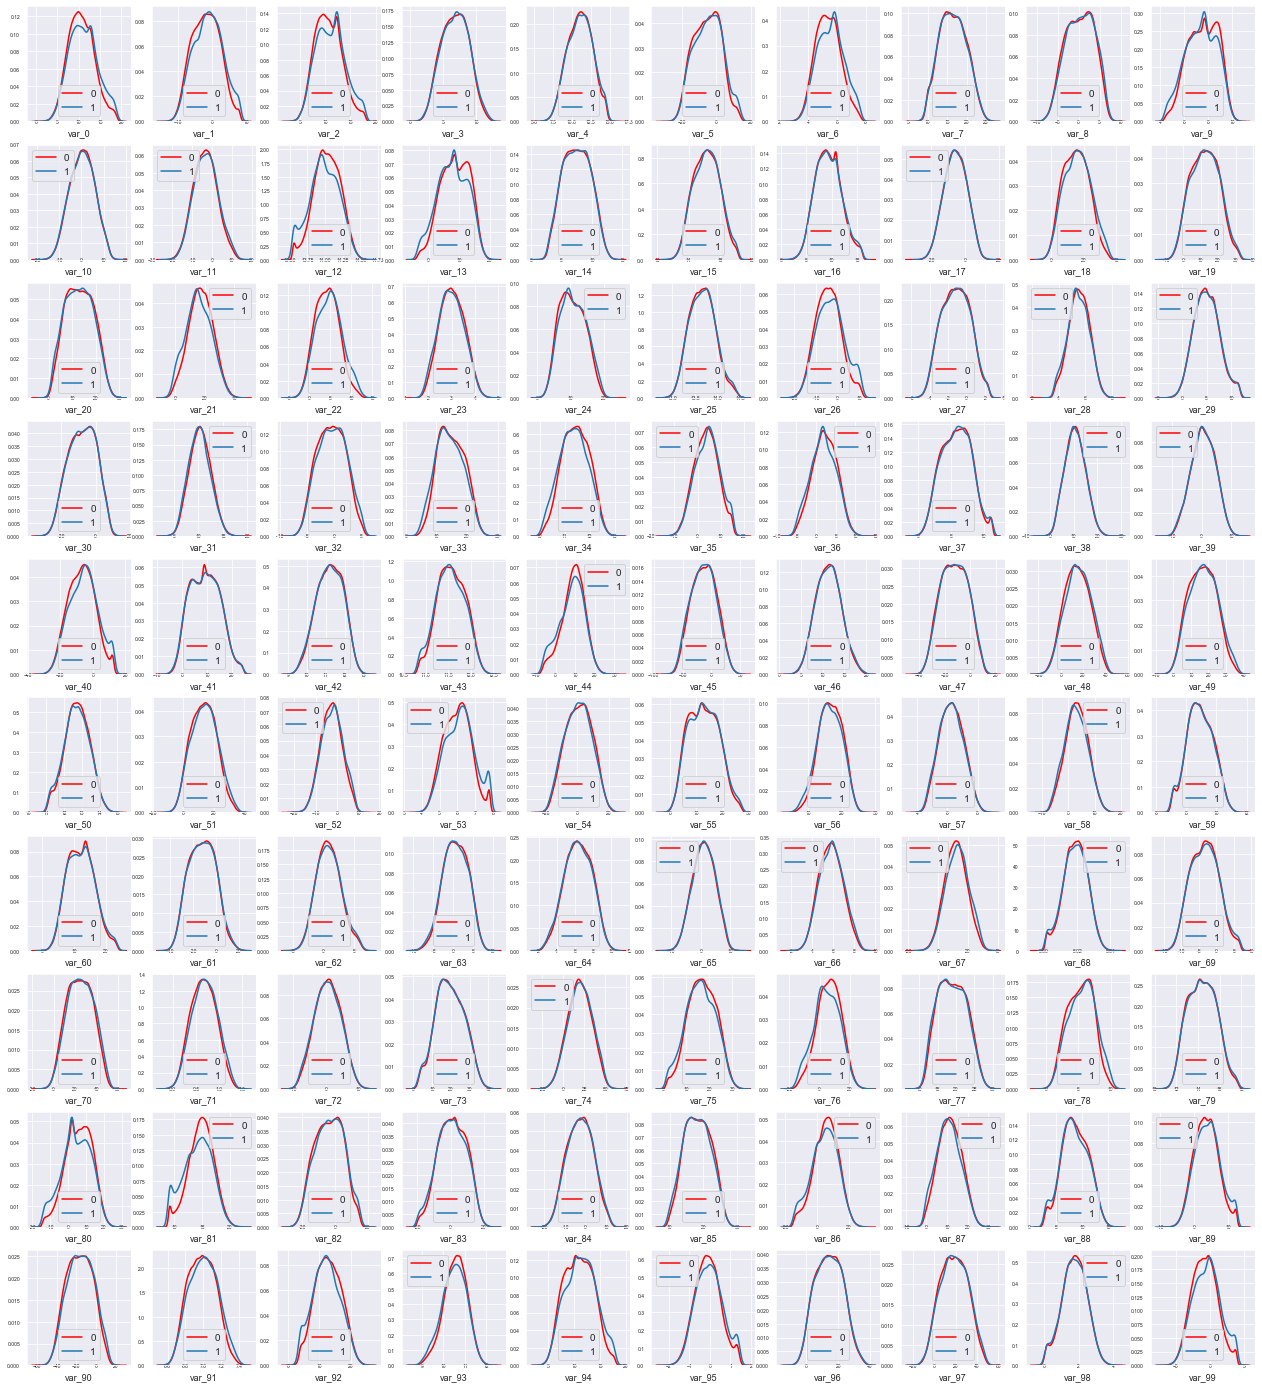

In [17]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
features = df_train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

The last 100 variables from **var_100** till **var_199** are depicted in the following cell:

<Figure size 432x288 with 0 Axes>

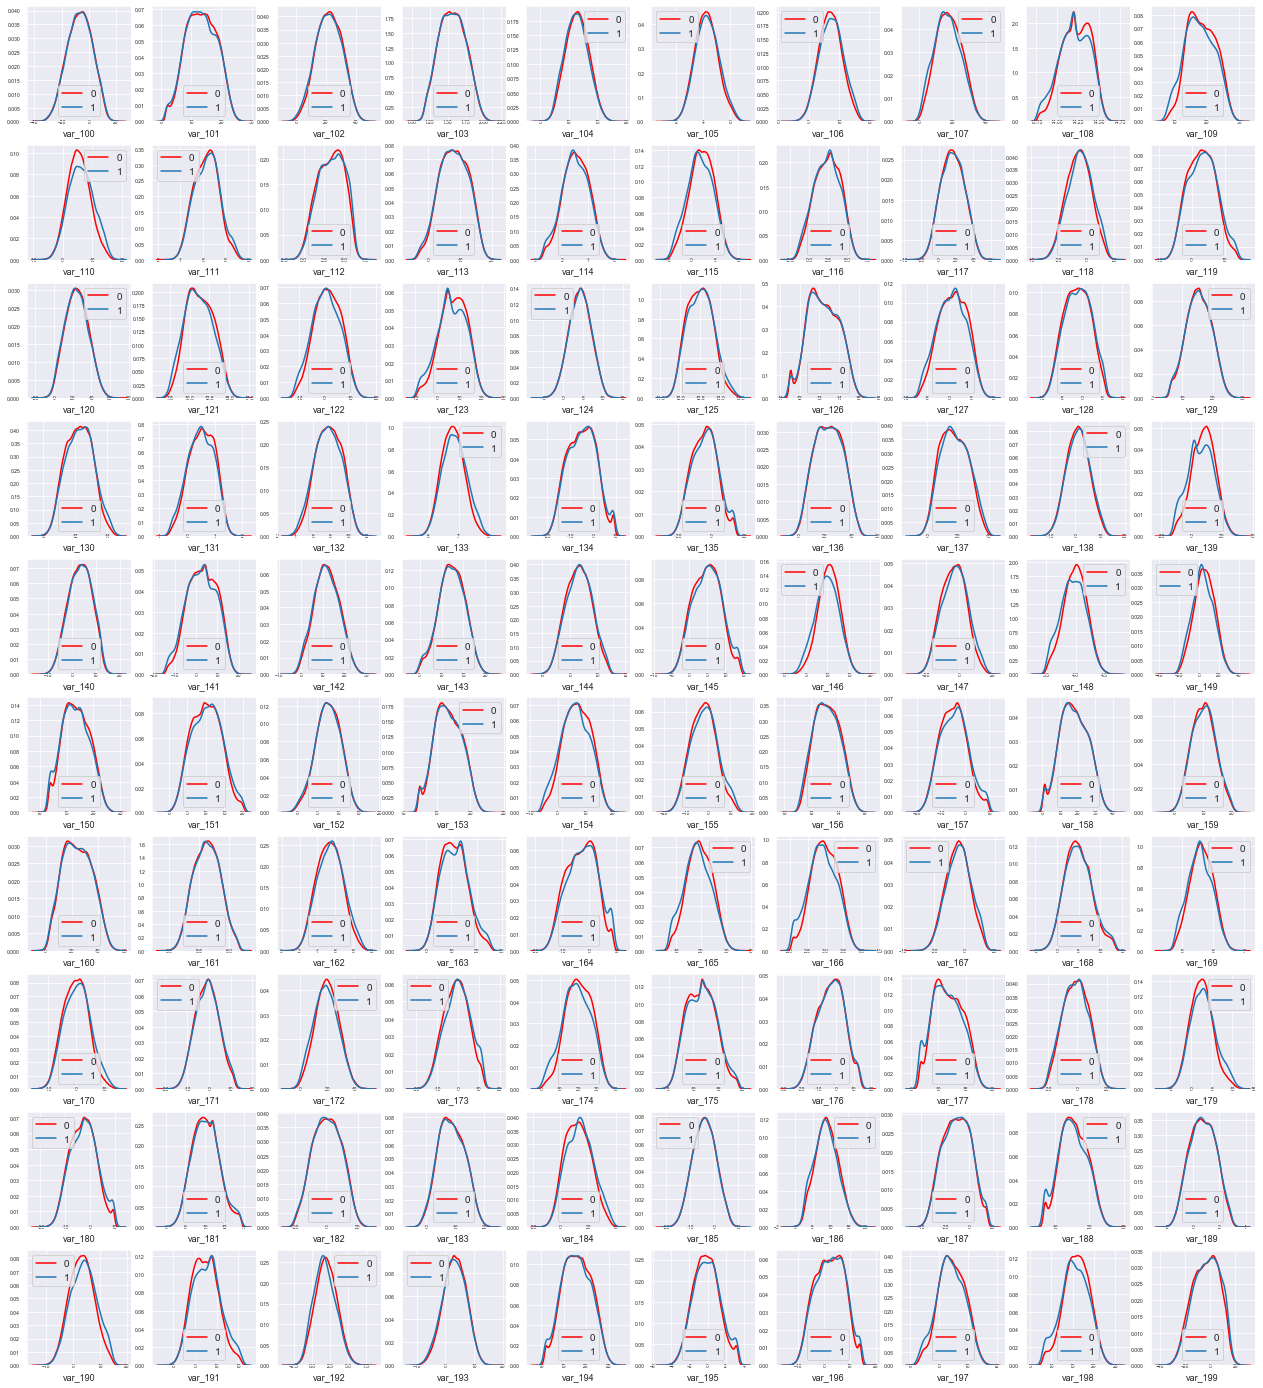

In [18]:
features = df_train.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

We can observe that there is a considerable number of features with significant different distribution for the two target values.  
For example, **var_0**, **var_1**, **var_2**, **var_6**, **var_9**, **var_13**, **var_106**, **var_109**, **var_139** and many others.

Some features, such as **var_2**, **var_13**, **var_26**, **var_55**, **var_175**, **var_184**, **var_196** show a distribution that resembles to a **bivariate distribution**.

In statistics, **bivariate data is data on each of two variables, where each value of one of the variables is paired with a value of the other variable. Typically it would be of interest to investigate the possible association between the two variables**

We will take this into consideration in the future for the selection of the features for our prediction model.  

Le't s now look at the distribution of the same features in parallel in train and test datasets. 

The first 100 values are displayed in the following cell

Let's show now the density plot of variables in train and test dataset. 

## Comparision of of train and test data for each variable 

We will be representing with different **colors** the **distribution** for values with **each variable** value for **train** and **test**.

The first 100 variables from **var_0** till **var_99** are depicted in the following cell:

<Figure size 432x288 with 0 Axes>

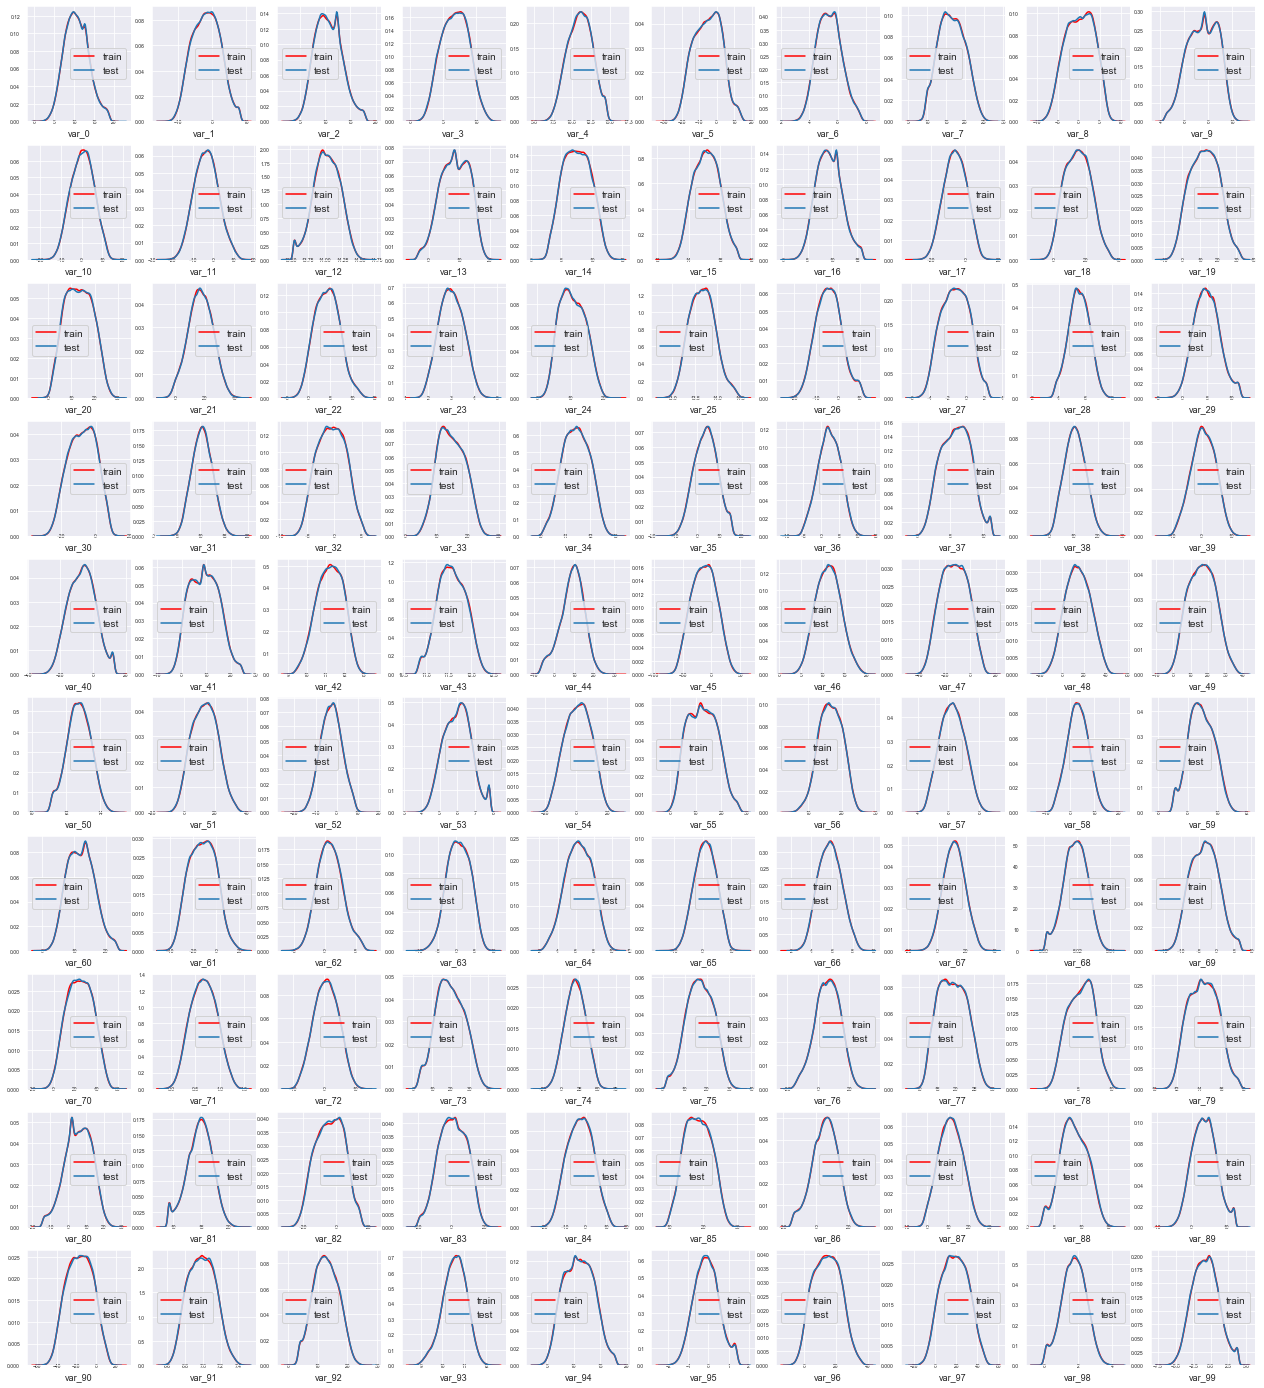

In [19]:
features = df_train.columns.values[2:102]
plot_feature_distribution(df_train, df_test, 'train', 'test', features)

The last 100 variables from **var_100** till **var_199** are depicted in the following cell:

<Figure size 432x288 with 0 Axes>

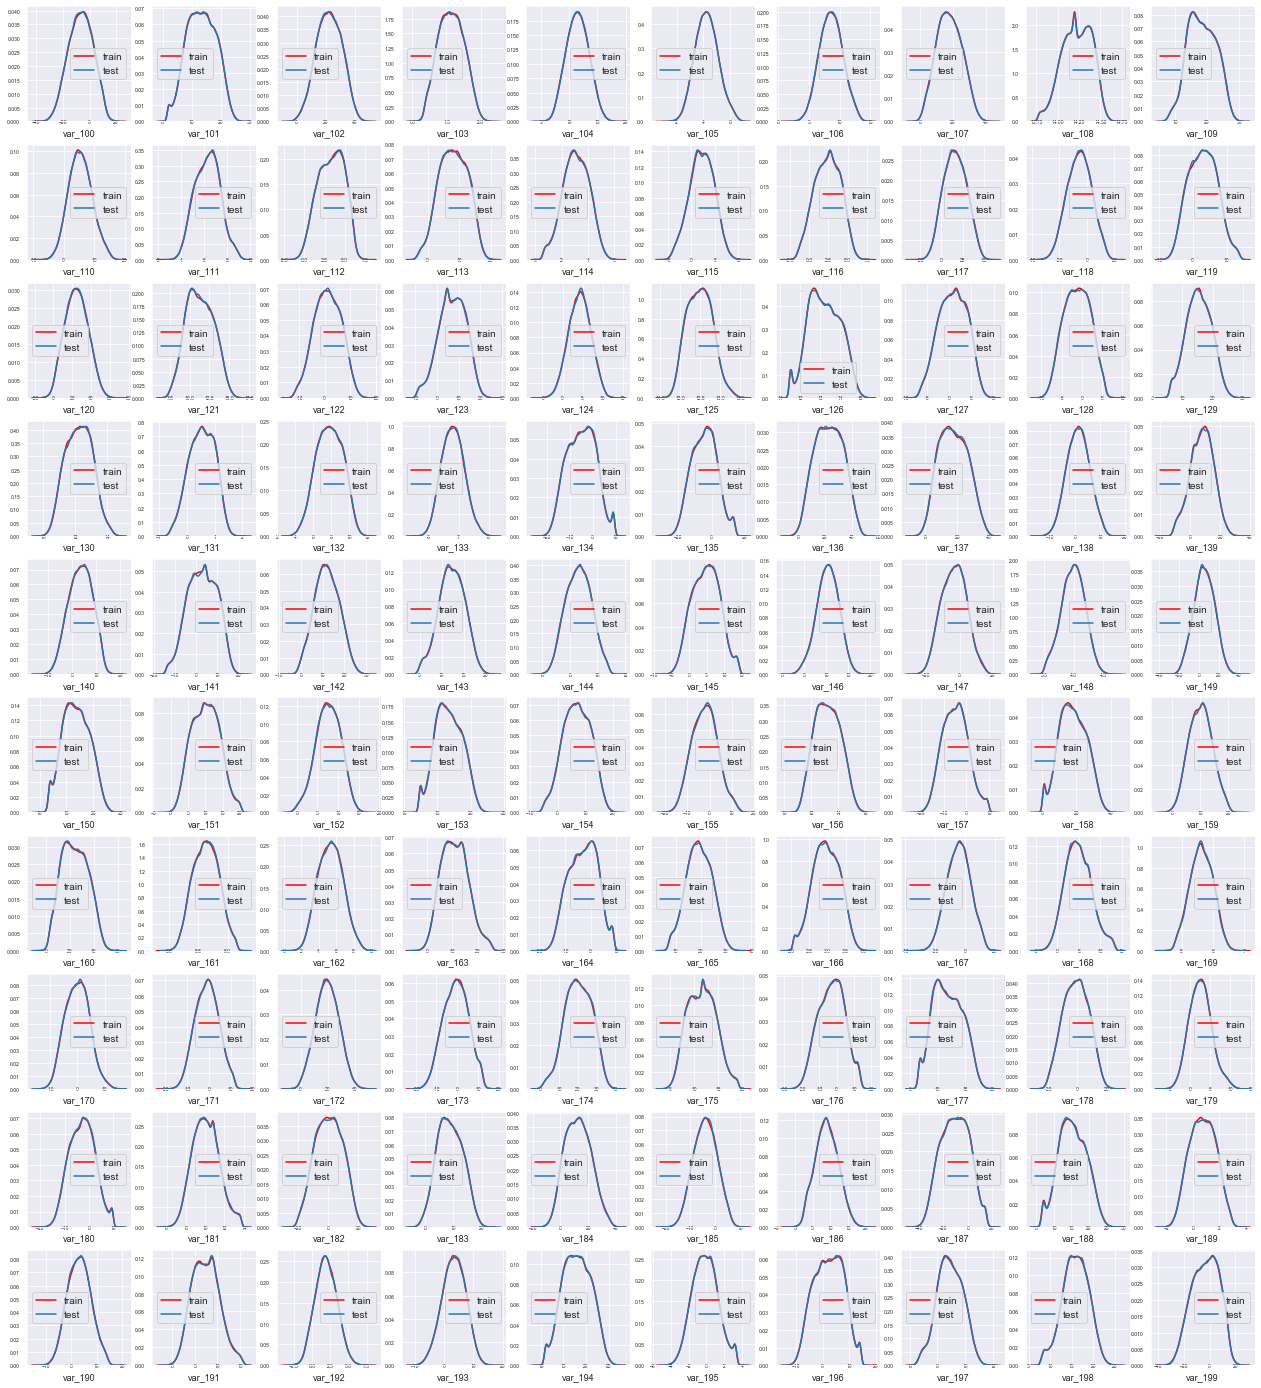

In [20]:
features = df_train.columns.values[102:202]
plot_feature_distribution(df_train, df_test, 'train', 'test', features)

The train and test seems to be well ballanced with respect with distribution of the numeric variables.  

## <a id='33'>Distribution of mean and std</a>  



Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target.

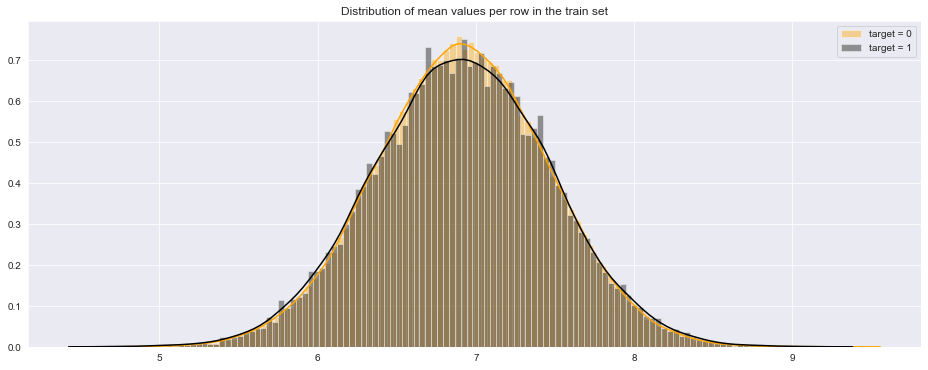

In [21]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="black", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's check now the distribution of the mean value per column in the train dataset, grouped by value of target.

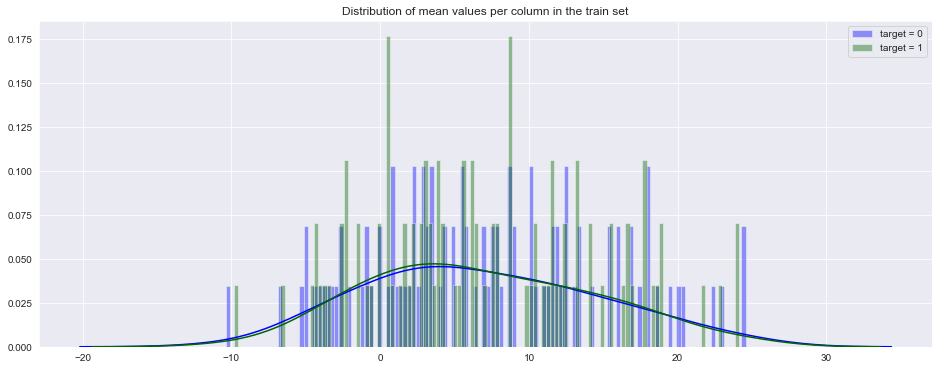

In [22]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkgreen", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## <a id='34'>Distribution of min and max</a>  

Let's check the distribution of min per row in the train and test set.

Let's show now the distributions of min values per row in train set, separated on the values of target (0 and 1).

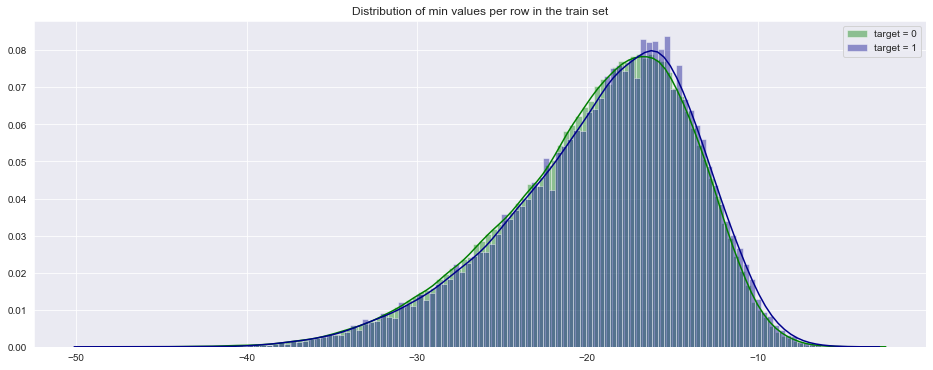

In [23]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

We show here the distribution of min values per columns in train set.

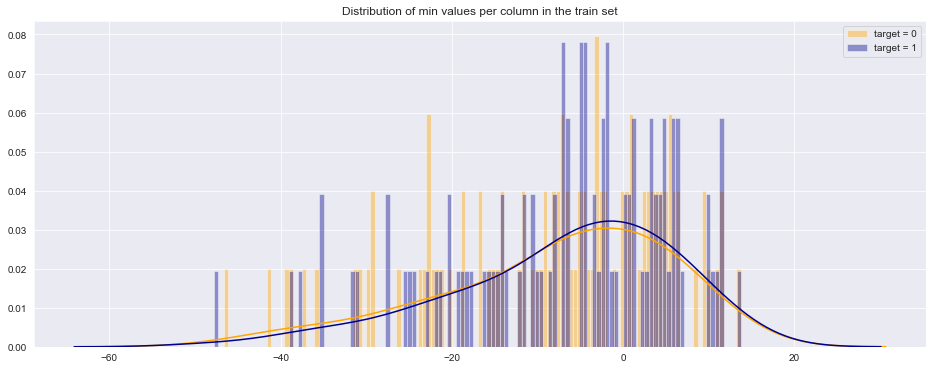

In [24]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's show now the distribution of max values per rown in the train set.

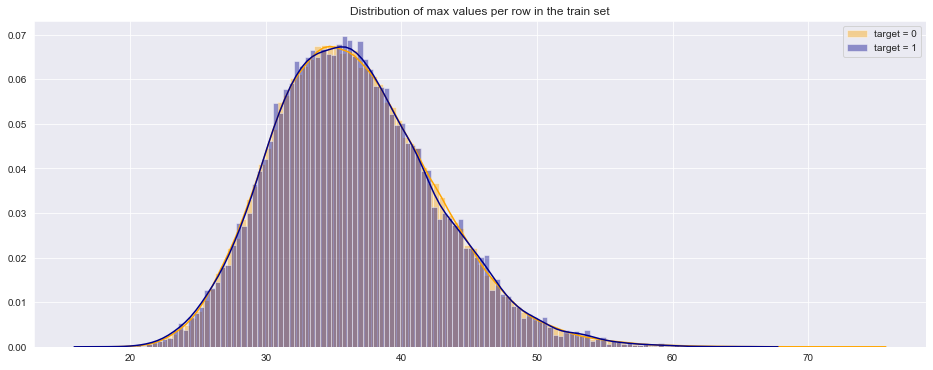

In [25]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's show also the distribution of max values per columns in the train set.

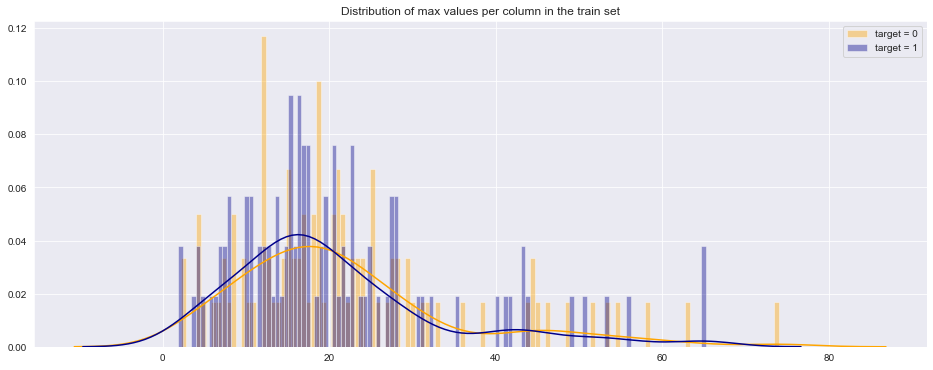

In [26]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# Anova for numerical inputs
Reason for choosing anova: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
The p value obtained from ANOVA analysis for 181 variables is significant (p < 0.05), and therefore, we conclude that there are significant differences among target variable.


In [27]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
rowIndex=0
features = [c for c in df_train.columns if c not in ['ID_code', 'target']]
target = df_train['target']
columns = ['P-value','variable']
df_for_anova = pd.DataFrame(columns=columns)
for column in features:
    rowIndex =  rowIndex+1
    column1 = str(column)
    cw_lm=ols('target ~'+ column1, data=df_train).fit()
#    cw_lm=ols('Call_Flag ~ C('+column1+')', data=df).fit() #Specify C for Categorical
    x = sm.stats.anova_lm(cw_lm, typ=2)
    df_for_anova.loc[rowIndex, 'P-value'] = x['PR(>F)'][0]
    df_for_anova.loc[rowIndex, 'variable'] = column1
df_for_anova1 = df_for_anova

In [28]:
def highlight_max(s):
    is_min = s == s.max()
    return ['background-color: orange' if v else '' for v in is_min]    
# Highlighting the minimum values of train_score and test_score 
df_for_anova = df_for_anova.style.\
    apply(highlight_max,subset=['P-value'])
df_for_anova

In [29]:
#df_train = pd.read_csv("train.csv")
result = df_for_anova1.sort_values(['P-value'], ascending=[0])
features_selected = result[result['P-value'] <= 0.05] 
features_not_selected = result[result['P-value'] > 0.05] 
features_selected = features_selected['variable'].to_list()
features_not_selected = features_not_selected['variable'].to_list()
print(features_not_selected)

['var_185', 'var_27', 'var_30', 'var_17', 'var_38', 'var_41', 'var_126', 'var_103', 'var_10', 'var_100', 'var_117', 'var_7', 'var_96', 'var_136', 'var_158', 'var_98', 'var_39', 'var_161', 'var_124']


In [30]:
df_train_limited = df_train.drop(features_not_selected, axis=1)
df_train_limited.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

    var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0 -4.9200  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   7.8784   
1  3.1468  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   8.1267   
2 -4.9193  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417  -6.5213   
3 -5.8609  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706  -2.9275   
4  6.2654  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   3.9267   

   var_197  var_198  var_199  
0   8.5635  12.7803  -1.0914  
1   8.7889  18.3560   1.9518  
2   8.2675  14.7222   0.3965  
3  10.2922  17.9697  -8.9996  
4   9.5031  17.9974  -8.8104  

[5 rows x 183 columns]

In [31]:
df_test_limited = df_test.drop(features_not_selected, axis=1)
df_test_limited.head()

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6   var_8  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493  2.1337   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196 -4.4131   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950  1.5233   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397  3.3755   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595  2.9890   

    var_9  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0  8.8100  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669   4.3654   
1  5.9739  ...  10.6165   8.8349   0.9403  10.1282  15.5765   0.4773  -1.4852   
2  8.3442  ...  -0.7484  10.9935   1.9803   2.1800  12.9813   2.1281  -7.1086   
3  7.4578  ...   9.5702   9.0766   1.6580   3.5813  15.1874   3.1656   3.9567   
4  7.1437  ...   4.2259   9.1723   1.2835   3.3778  19.5542  -0.2860  -5.1612   

   var_197  var_198  var_199  
0  10.7200  15.4722  -8.7197  
1   9.8714  19.1293 -20.9760  
2   7.0618  19.8956 -23.1794  
3   9.2295  13.0168  -4.2108  
4   7.2882  13.9260  -9.1846  

[5 rows x 182 columns]

## <a id='36'>Features correlation</a>  

We calculate now the correlations between the features in train set.  
The following table shows the first 10 the least correlated features.

In [32]:
%%time
correlations = df_train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

Wall time: 17.6 s


Let's look to the top most correlated features, besides the same feature pairs.

In [33]:
correlations.tail(10)

level_0  level_1         0
39790  var_183  var_189  0.009359
39791  var_189  var_183  0.009359
39792  var_174   var_81  0.009490
39793   var_81  var_174  0.009490
39794   var_81  var_165  0.009714
39795  var_165   var_81  0.009714
39796   var_53  var_148  0.009788
39797  var_148   var_53  0.009788
39798   var_26  var_139  0.009844
39799  var_139   var_26  0.009844

Let's see also the least correlated features.

In [34]:
correlations.head(10)

level_0  level_1             0
0   var_75  var_191  2.703975e-08
1  var_191   var_75  2.703975e-08
2  var_173    var_6  5.942735e-08
3    var_6  var_173  5.942735e-08
4  var_126  var_109  1.313947e-07
5  var_109  var_126  1.313947e-07
6  var_144   var_27  1.772502e-07
7   var_27  var_144  1.772502e-07
8  var_177  var_100  3.116544e-07
9  var_100  var_177  3.116544e-07

The correlation between the features is very small. 

## <a id='37'>Duplicate values</a>  

Let's now check how many duplicate values exists per columns.

In [35]:
%%time
features = df_train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = df_train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = df_test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

Wall time: 7.27 s


Let's show the top 15 max of duplicate values per train set.

In [36]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

68       108      126      12      91       103      148  \
Feature         var_68  var_108  var_126   var_12  var_91  var_103  var_148   
Max duplicates    1084      313      305      203      66       61       59   
Value           5.0214  14.1999  11.5356  13.5545  6.9785   1.6662   4.0456   

                   71       161      25       125      169      166      133  \
Feature         var_71  var_161   var_25  var_125  var_169  var_166  var_133   
Max duplicates      54       52       41       40       39       39       39   
Value           0.7031   5.7688  13.6723  12.5159   5.6941   2.7306   6.8632   

                    43   
Feature          var_43  
Max duplicates       39  
Value           11.4522

Let's see also the top 15 number of duplicates values per test set.

In [37]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

68       126      108      12      91       103      148  \
Feature         var_68  var_126  var_108   var_12  var_91  var_103  var_148   
Max duplicates    1104      307      302      188      86       78       74   
Value           5.0197  11.5357  14.1999  13.5546  6.9939   1.4659   4.0004   

                    161      25      71       43       166      125      169  \
Feature         var_161   var_25  var_71   var_43  var_166  var_125  var_169   
Max duplicates       69       60      60       58       53       53       51   
Value            5.7114  13.5965  0.5389  11.5738   2.8446  12.2189   5.8455   

                    133  
Feature         var_133  
Max duplicates       50  
Value            6.6873

Same columns in train and test set have the same or very close number of duplicates of same or very close values. This is an interesting pattern that we might be able to use in the future.

# <a id='5'>Modelling</a>  

From the train columns list, we drop the ID and target to form the features list.

In [38]:
features = [c for c in df_train.columns if c not in ['ID_code', 'target']]
target = df_train['target']

# Definition/Documentation of Hyperparameters for the model [4] [6]

1. **num_leaves**: number of leaves in full tree, default: 31
2. **min_data_in_leaf**: It is the minimum number of the records a leaf may have. The default value is 20, optimum value. It is also used to deal over fitting

 This is a very important parameter to **prevent over-fitting** in a leaf-wise tree. Its optimal value depends on the number of training samples and **num_leaves**. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
 
3. binary classification
4. **max_depth**: It describes the maximum depth of tree. This parameter is used to handle model overfitting. Any time you feel that your model is overfitted, my first advice will be to lower max_depth.
5. **learning_rate**: This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…
6. **boosting**: defines the type of algorithm you want to run, default=gdbt
**gbdt: traditional Gradient Boosting Decision Tree** 

7. **bagging_freq** 🔗︎, default = 0, type = int, aliases: subsample_freq
* frequency for bagging
* 0 means disable bagging; k means perform bagging at every k iteration. Every k-th iteration, LightGBM will randomly select bagging_fraction * 100 % of the data to use for the next k iterations
8. **bagging_fraction**: specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting.
* default = 1.0, type = double, aliases: sub_row, subsample, bagging, 
* constraints: 0.0 < bagging_fraction <= 1.0
* like feature_fraction, but this will randomly select part of data without resampling
* can be used to speed up training
* can be used to deal with over-fitting

bagging_fraction and bagging_freq: enables bagging (subsampling) of the training data. Both values need to be set for bagging to be used. The frequency controls how often (iteration) bagging is used. Smaller fractions and frequencies reduce overfitting. 

9. **boost_from_average** 🔗︎, default = true, type = bool ; used only in regression, binary, multiclassova and cross-entropy applications adjusts initial score to the mean of labels for faster convergence
10. **feature_fraction**: controls the subsampling of features used for training (as opposed to subsampling the actual training data in the case of bagging). **Smaller fractions reduce overfitting**.

11. **metric**: Area under the curve
12. **min_sum_hessian_in_leaf** 🔗︎, default = 1e-3, type = double, aliases: min_sum_hessian_per_leaf, min_sum_hessian, min_hessian, min_child_weight, constraints: min_sum_hessian_in_leaf >= 0.0
minimal sum hessian in one leaf. **Like min_data_in_leaf, it can be used to deal with over-fitting**
13. **num_threads**: for the best speed, set this to the number of real CPU cores, not the number of threads (most CPUs use hyper-threading to generate 2 threads per CPU core)

***early_stopping_round**: This parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations.


In [39]:
param = {
    'num_leaves': 13, #default = 31
    'min_data_in_leaf': 80,
    'objective': 'binary', #default = regression
    'max_depth': -1,
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'bagging_freq': 5,
    'bagging_fraction': 0.4, #For tuning overfitting
    'boost_from_average':'false', 
    'feature_fraction': 0.05, #For tuning overfitting
    'metric':'auc', 
    'min_sum_hessian_in_leaf': 10.0,
    'num_threads': 8,
}

# sklearn.model_selection.StratifiedKFold Documentation

**n_splitsint**, default=5
Number of folds. Must be at least 2.)

**shufflebool**, default=False
Whether to shuffle each class’s samples before splitting into batches. Note that the samples within each split will not be shuffled.

**random_stateint**, RandomState instance or None, default=None
When shuffle is True, random_state affects the ordering of the indices, which controls the randomness of each fold for each class. Otherwise, leave random_state as None. Pass an int for reproducible output across multiple function calls. 

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html:
* Predict
* save
* use best_iteration


# Running the model

If we want the splits to be reproducible, we also need to pass in an integer to random_state parameter.

In [40]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=2000, early_stopping_rounds = 500)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits
    
#clf.save_model('model.txt', num_iteration=clf.best_iteration)
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 500 rounds
[2000]	training's auc: 0.91108	valid_1's auc: 0.888456
[4000]	training's auc: 0.924559	valid_1's auc: 0.895461
[6000]	training's auc: 0.933681	valid_1's auc: 0.898102
[8000]	training's auc: 0.941391	valid_1's auc: 0.899151
[10000]	training's auc: 0.948235	valid_1's auc: 0.899685
Early stopping, best iteration is:
[10663]	training's auc: 0.950394	valid_1's auc: 0.899804
Fold 1
Training until validation scores don't improve for 500 rounds
[2000]	training's auc: 0.910905	valid_1's auc: 0.889932
[4000]	training's auc: 0.924601	valid_1's auc: 0.896229
[6000]	training's auc: 0.933804	valid_1's auc: 0.898428
[8000]	training's auc: 0.941375	valid_1's auc: 0.899039
Early stopping, best iteration is:
[8842]	training's auc: 0.944408	valid_1's auc: 0.899206
Fold 2
Training until validation scores don't improve for 500 rounds
[2000]	training's auc: 0.911673	valid_1's auc: 0.884361
[4000]	training's auc: 0.925198	valid_1's auc: 0.8

NameError: name 'roc_auc_score' is not defined

In [42]:
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

CV score: 0.90044 


# **Modelling with selected features only (181)**

In [50]:
#features_selected, features_not_selected, df_train_limited, df_test_limited
df_test_limited.head()

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6   var_8  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493  2.1337   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196 -4.4131   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950  1.5233   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397  3.3755   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595  2.9890   

    var_9  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0  8.8100  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669   4.3654   
1  5.9739  ...  10.6165   8.8349   0.9403  10.1282  15.5765   0.4773  -1.4852   
2  8.3442  ...  -0.7484  10.9935   1.9803   2.1800  12.9813   2.1281  -7.1086   
3  7.4578  ...   9.5702   9.0766   1.6580   3.5813  15.1874   3.1656   3.9567   
4  7.1437  ...   4.2259   9.1723   1.2835   3.3778  19.5542  -0.2860  -5.1612   

   var_197  var_198  var_199  
0  10.7200  15.4722  -8.7197  
1   9.8714  19.1293 -20.9760  
2   7.0618  19.8956 -23.1794  
3   9.2295  13.0168  -4.2108  
4   7.2882  13.9260  -9.1846  

[5 rows x 182 columns]

In [51]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=22000)
oof_fs = np.zeros(len(df_train_limited))
predictions_fs = np.zeros(len(df_test_limited))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_limited.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train_limited.iloc[trn_idx][features_selected], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train_limited.iloc[val_idx][features_selected], label=target.iloc[val_idx])

    num_round = 1000000
    clf_fs = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=2000, early_stopping_rounds = 500)
    oof_fs[val_idx] = clf_fs.predict(df_train_limited.iloc[val_idx][features_selected], num_iteration=clf_fs.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features_selected
    fold_importance_df["importance"] = clf_fs.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_fs += clf_fs.predict(df_test_limited[features_selected], num_iteration=clf_fs.best_iteration) / folds.n_splits
    
clf_fs.save_model('model_fs.txt', num_iteration=clf_fs.best_iteration)
print("CV score fs model: {:<8.5f}".format(roc_auc_score(target, oof_fs)))

Fold 0
Training until validation scores don't improve for 500 rounds
[2000]	training's auc: 0.911177	valid_1's auc: 0.889045
[4000]	training's auc: 0.924391	valid_1's auc: 0.896434
[6000]	training's auc: 0.933364	valid_1's auc: 0.899001
[8000]	training's auc: 0.940771	valid_1's auc: 0.900103
Early stopping, best iteration is:
[8070]	training's auc: 0.941015	valid_1's auc: 0.90012
Fold 1
Training until validation scores don't improve for 500 rounds
[2000]	training's auc: 0.911146	valid_1's auc: 0.890085
[4000]	training's auc: 0.924433	valid_1's auc: 0.896637
[6000]	training's auc: 0.933532	valid_1's auc: 0.898999
Early stopping, best iteration is:
[7310]	training's auc: 0.938532	valid_1's auc: 0.900055
Fold 2
Training until validation scores don't improve for 500 rounds
[2000]	training's auc: 0.911539	valid_1's auc: 0.884639
[4000]	training's auc: 0.924943	valid_1's auc: 0.892087
[6000]	training's auc: 0.933907	valid_1's auc: 0.894556
[8000]	training's auc: 0.941183	valid_1's auc: 0.895

Keeping everything else the same, our best Cross-validation score improved from **0.90044** to **0.90065**.

**LGBMClassifier** is the **sklearn interface**. The .fit(X, y) call is standard sklearn syntax for model training. It is a class object for you to use as part of sklearn's ecosystem (for running pipelines, parameter tuning etc.). For our use case, we will using this for **ELI5** model interpretability.

**lightgbm.train** is the core training API for lightgbm itself.

In [53]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X = df_train.drop(['ID_code', 'target'], axis=1)
y = df_train['target']
model1 = lgb.LGBMClassifier(**param,n_estimators = 200,n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2,stratify=target)
model1.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=2000, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.879585	valid_1's auc: 0.862658


LGBMClassifier(bagging_fraction=0.4, bagging_freq=5, boost_from_average='false',
               boosting='gbdt', feature_fraction=0.05, learning_rate=0.01,
               metric='auc', min_data_in_leaf=80, min_sum_hessian_in_leaf=10.0,
               n_estimators=200, num_leaves=13, num_threads=8,
               objective='binary')

**Modelling with selected features only (181)**

In [52]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X_fs = df_train_limited.drop(['ID_code', 'target'], axis=1)
y_fs = df_train_limited['target']
model1_fs = lgb.LGBMClassifier(**param,n_estimators = 200000,n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(X_fs,y_fs,test_size = 0.2,stratify=target)
model1_fs.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=2000, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
[2000]	training's auc: 0.913801	valid_1's auc: 0.891
[4000]	training's auc: 0.927433	valid_1's auc: 0.896832
[6000]	training's auc: 0.936864	valid_1's auc: 0.898553
[8000]	training's auc: 0.944683	valid_1's auc: 0.898878
Early stopping, best iteration is:
[7602]	training's auc: 0.943217	valid_1's auc: 0.898926


LGBMClassifier(bagging_fraction=0.4, bagging_freq=5, boost_from_average='false',
               boosting='gbdt', feature_fraction=0.05, learning_rate=0.01,
               metric='auc', min_data_in_leaf=80, min_sum_hessian_in_leaf=10.0,
               n_estimators=200000, num_leaves=13, num_threads=8,
               objective='binary')

In [55]:
model1

LGBMClassifier(bagging_fraction=0.4, bagging_freq=5, boost_from_average='false',
               boosting='gbdt', feature_fraction=0.05, learning_rate=0.01,
               metric='auc', min_data_in_leaf=80, min_sum_hessian_in_leaf=10.0,
               n_estimators=200, num_leaves=13, num_threads=8,
               objective='binary')

Let's check the feature importance.

Feature  importance  fold
0     var_29         257     1
1    var_160         267     1
2    var_183         299     1
3     var_46         240     1
4    var_129         297     1
5     var_60         384     1
6     var_14         299     1
7     var_73         302     1
8    var_153         301     1
9    var_182         272     1
10    var_61         363     1
11   var_176         345     1
12    var_79         346     1
13    var_37         280     1
14    var_16         291     1
15    var_69         364     1
16    var_42         319     1
17    var_47         262     1
18   var_101         375     1
19   var_189         320     1
20    var_59         265     1
21   var_152         390     1
22   var_120         377     1
23     var_4         353     1
24     var_3         347     1
25   var_143         381     1
26    var_65         338     1
27    var_19         344     1
28    var_68         355     1
29    var_84         321     1
..       ...         ...   ...
151   var_44         688    10
152   var_40         782    10
153  var_109         785    10
154  var_179         688    10
155  var_115         795    10
156    var_1         826    10
157    var_0         710    10
158   var_34         908    10
159  var_198         807    10
160  var_133         824    10
161  var_148         778    10
162   var_13         912    10
163  var_165         855    10
164    var_2         776    10
165  var_190         816    10
166   var_80         853    10
167  var_166         830    10
168   var_99         891    10
169   var_21         787    10
170   var_22         844    10
171  var_174         828    10
172   var_76         874    10
173   var_26         807    10
174   var_53         801    10
175  var_146         862    10
176  var_110         757    10
177    var_6         772    10
178   var_12         796    10
179  var_139         811    10
180   var_81         722    10

[1810 rows x 3 columns]

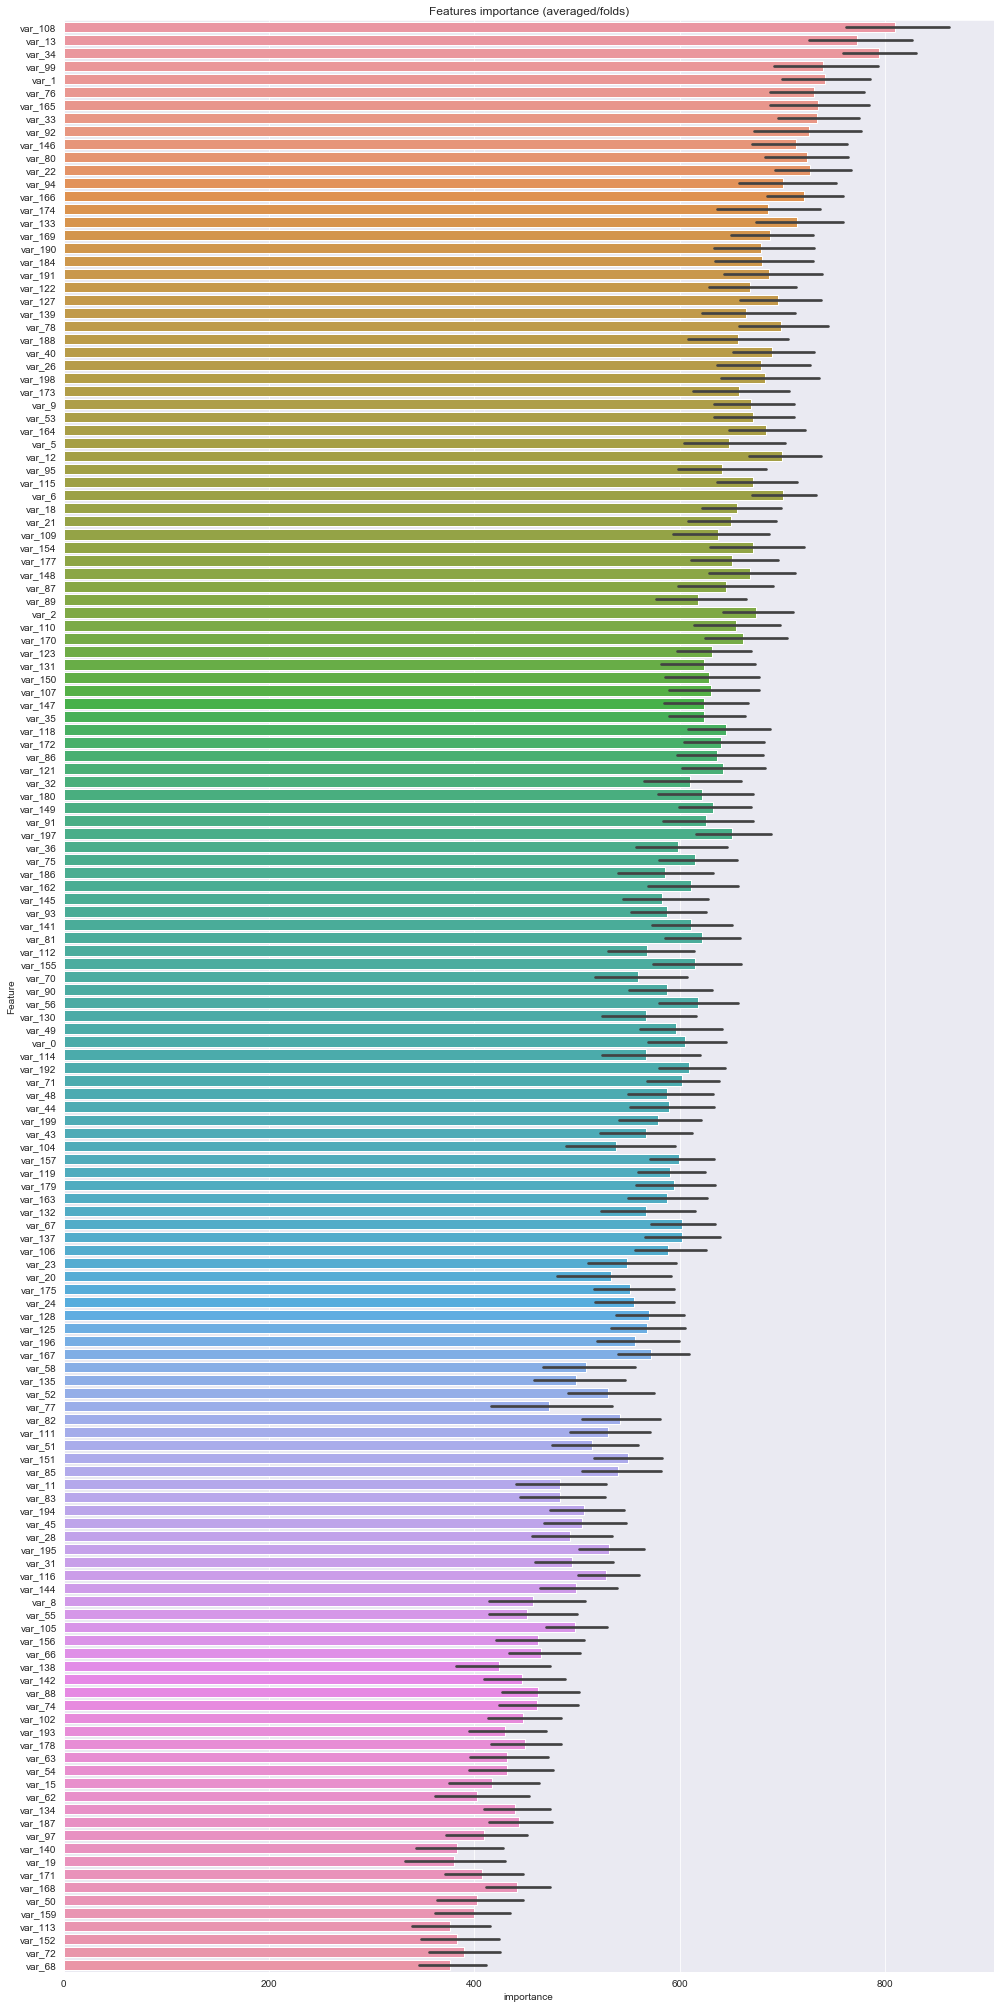

In [56]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')
feature_importance_df

# <a id='6'>Submission</a>  

I submit the solution some days ago. The score (Area Under Receiver Operating Charachteristic Curve) received on this submission is **0.90035** which places my position in the private leaderboard as **324** ( I ranked it myself due to late submission) out of **8751 total submissions** ranking me in **TOP 4 %**. 

**Person winning** the competition received a score of **0.92573**.

![title](leaderboard.png)

In [58]:
# a = predictions
# a[a > 0.5] = 1
# a[a <= 0.5] = 0
#print(a)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions_fs
sub_df.to_csv("submission_2_fs.csv", index=False)
sub_df

ID_code    target
0            test_0  0.094051
1            test_1  0.203797
2            test_2  0.174657
3            test_3  0.201272
4            test_4  0.042396
5            test_5  0.002162
6            test_6  0.005764
7            test_7  0.178578
8            test_8  0.002587
9            test_9  0.007620
10          test_10  0.219842
11          test_11  0.030809
12          test_12  0.045373
13          test_13  0.026536
14          test_14  0.008281
15          test_15  0.035863
16          test_16  0.380287
17          test_17  0.027936
18          test_18  0.199134
19          test_19  0.010768
20          test_20  0.309214
21          test_21  0.073872
22          test_22  0.007287
23          test_23  0.039637
24          test_24  0.012306
25          test_25  0.118499
26          test_26  0.084860
27          test_27  0.014845
28          test_28  0.274041
29          test_29  0.085621
...             ...       ...
199970  test_199970  0.051264
199971  test_199971  0.161081
199972  test_199972  0.005223
199973  test_199973  0.063648
199974  test_199974  0.006378
199975  test_199975  0.081339
199976  test_199976  0.221027
199977  test_199977  0.214781
199978  test_199978  0.032288
199979  test_199979  0.087027
199980  test_199980  0.064718
199981  test_199981  0.044027
199982  test_199982  0.026679
199983  test_199983  0.029794
199984  test_199984  0.017175
199985  test_199985  0.166521
199986  test_199986  0.522097
199987  test_199987  0.043798
199988  test_199988  0.014579
199989  test_199989  0.033562
199990  test_199990  0.005774
199991  test_199991  0.007452
199992  test_199992  0.310561
199993  test_199993  0.011620
199994  test_199994  0.084819
199995  test_199995  0.040362
199996  test_199996  0.008045
199997  test_199997  0.005024
199998  test_199998  0.095623
199999  test_199999  0.065822

[200000 rows x 2 columns]

# Model interpretation

**ELI5** is a python package that is used to **inspect ML classifiers** and **explain their predictions**. 
It is popularly used to debug algorithms such as **sklearn regressors** and **classifiers, XGBoost, CatBoost, Keras**, etc.  
You can read more about the package <a href="https://github.com/TeamHG-Memex/eli5">here</a>

In [59]:
features

['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_79',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90',
 'var_91'

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
eli5.show_weights(model1, targets=[0, 1], feature_names=list(X.columns), top=200, feature_filter=lambda x: x != '<BIAS>')

# TO DOs:
* Try t-test along with anova
* Select k-best features as mentioned in Jason Brownlee's article [7] .
* Remove last x features having most correlation in correlation test
* Try xgboost and compare results with LightGBM
* Writing a script for real-time prediction (not necessary in current scenario)
* Remove x features with least weight in the model
* min-max scaling had worse results, try some other normalization

# <a id='7'>References</a>    

[1] https://www.avanwyk.com/an-overview-of-lightgbm/  

[2] https://www.kaggle.com/chocozzz/santander-lightgbm-baseline-lb-0-897  

[3] https://www.kaggle.com/brandenkmurray/nothing-works

[4] https://lightgbm.readthedocs.io/en/latest/Parameters.html

[5] https://towardsdatascience.com/how-to-train-test-split-kfold-vs-stratifiedkfold-281767b93869

[6] https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

[7] https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/